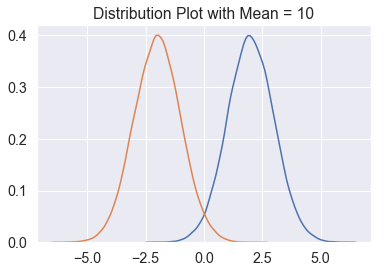

In [1]:
import numpy as np

# NOTE: we are storing y's as 1's or 0's but still doing the mean stuff correctly
def get_sample(n, mean, var):
    x_sample = []
    y_sample = []
    for i in range(n):
        y = np.random.binomial(1, .5)
        if (y == 0):
            x = np.random.normal(-mean, var)
        else:
            x = np.random.normal(mean, var)
        x_sample.append(x)
        y_sample.append(y)
    return x_sample, y_sample

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(font_scale=1.3)

def split_by_class(sample):
    y_one = [pair for pair in sample if pair[1] == 1]
    y_neg_one = [pair for pair in sample if pair[1] == 0]
    return y_one, y_neg_one

X, y = get_sample(100000, 2, 1)
sample = list(zip(X, y))
class_one, class_neg_one = split_by_class(sample)
sns.distplot(list(zip(*class_one))[0], hist=False)
sns.distplot(list(zip(*class_neg_one))[0], hist=False)
plt.title("Distribution Plot with Mean = 10")
plt.show()

In [2]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from scipy.stats import entropy

def CART_estimate(X, y, n_trees = 300, bootstrap = True, depth = 30):
    model = RandomForestClassifier(bootstrap = bootstrap, n_estimators =n_trees, max_depth = depth, max_features = math.ceil(int(math.sqrt(X.shape[1]))))
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree_in_forest in model:
        # get number of training elements in each partition
        node_counts = tree_in_forest.tree_.n_node_samples
        # get counts for all x (x.length array)
        partition_counts = np.asarray([node_counts[x] for x in tree_in_forest.apply(X)])
        # get class probability for all x (x.length, n_classes)
        class_probs = tree_in_forest.predict_proba(X)
        # get elements by performing row wise multiplication
        elems = np.multiply(class_probs, partition_counts[:, np.newaxis])
        # update counts for that tree
        class_counts += elems
    probs = class_counts/class_counts.sum(axis=1, keepdims=True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
def honesty_estimate(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))

        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

In [4]:
def cef_estimate(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

# RUN MULTIPLE TRIALS (cond entropy vs increasing n)

In [ ]:
from tqdm import tqdm_notebook
def get_cond_entropy_vs_n(mean):
    cef_all = []
    cart_all = []
    honest_all = []
    sample_sizes = [i*50 for i in range(1, 51)]
    for i in tqdm_notebook(range(5)):
        cef = []
        cart = []
        honest = []
        for elem in tqdm_notebook(sample_sizes):
            X, y = get_sample(elem, mean, 1)
            cef.append(cef_estimate(np.array(X).reshape(-1, 1), y, 300, .32, depth = 30))
            cart.append(CART_estimate(np.array(X).reshape(-1, 1), y, 300, .32, depth = 30))
            honest.append(honesty_estimate(np.array(X).reshape(-1, 1), y, 300, .32, depth = 30))
        cef_all.append(cef)
        cart_all.append(cart)
        honest_all.append(honest)
    return sample_sizes, cef_all, cart_all, honest_all

sample_sizes, cef, cart, honest = get_cond_entropy_vs_n(1)


# PLOT

In [ ]:
sns.set(font_scale = 3.5)
sns.set_style("ticks")
plt.figure()
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(sample_sizes, np.mean(cef, axis = 0).flatten(), label = "UF", linewidth = 2, color = "#F41711")
plt.plot(sample_sizes, np.mean(cart, axis = 0).flatten(), label = "CART", linewidth = 2, color = "#35978f")
plt.plot(sample_sizes, np.mean(honest, axis = 0).flatten(), label = "Honesty", linewidth = 2, color = "#fdae61")


for i in range(1, len(cef)):
    plt.plot(sample_sizes, cef[i], linewidth = 4, color = "#F41711", alpha = .15)
    
for i in range(1, len(cart)):
    plt.plot(sample_sizes, cart[i], linewidth = 4, color = "#35978f", alpha = .15)

for i in range(1, len(honest)):
    plt.plot(sample_sizes, honest[i], linewidth = 4, color = "#fdae61", alpha = .15)

line_true = plt.axhline(y=.356,linestyle='-', color = "black", label = "Truth")

plt.xlabel("Sample Size")
plt.ylabel("$\hat H(Y|X)$")
plt.ylim(ymin = 0)
plt.ylim(ymax = .8)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
plt.legend()
#plt.title("H(Y|X) Estimate vs Sample Size with Mean = 1")
plt.tight_layout()
plt.savefig("f19/alg_comparison_final_noerror_20_f19.pdf")
plt.show()

# Cond entropy vs increasing size effect

In [ ]:
from tqdm import tqdm_notebook
def get_cond_entropy_vs_mean(n):
    cef_all = []
    cart_all = []
    honest_all = []
    means = [i*.2 for i in range(1, 26)]
    for i in tqdm_notebook(range(1)):
        cef = []
        cart = []
        honest = []
        for elem in tqdm_notebook(means):
            X, y = get_sample(n, elem, 1)
            cef.append(cef_estimate(np.array(X).reshape(-1, 1), y, 300, .32, depth = 30))
            cart.append(CART_estimate(np.array(X).reshape(-1, 1), y, 300, .32, depth = 30))
            honest.append(honesty_estimate(np.array(X).reshape(-1, 1), y, 300, .32, depth = 30))
        return means, cef, cart, honest
        cef_all.append(cef)
        cart_all.append(cart)
        honest_all.append(honest)
    return means, cef_all, cart_all, honest_all

means, cef, cart, honest = get_cond_entropy_vs_mean(6000)


# Plot

In [6]:
# manually pulled this from another notebook at the time so i didn't have to copy over truth code... 

means = [i*.2 for i in range(1, 26)]
truth_conv_0 = [0.6735370073650998, 0.6189692437717479, 0.5399034434539033, 0.4486737716598367, 0.3563163602131132, 0.27102261528784277, 0.19775486449393131, 0.13857182418695446, 0.09331921299360335, 0.06042698682307801, 0.03763527535397637, 0.0225502735611931, 0.013000284813206697, 0.007211483620446213, 0.003849247530866684, 0.001976984201405685, 0.000977001437482805, 0.0004645526656417154, 0.00021252115348691092, 9.353507702591912e-05, 3.9603053948678024e-05, 1.6130245027223822e-05, 6.319574855861987e-06, 2.381477290036571e-06, 8.631660444180511e-07]

In [ ]:
sns.set(font_scale = 3.5)
sns.set_style("ticks")
plt.figure()
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['figure.figsize'] = [15, 10]

line_cf, = plt.plot(means, cef, label = "CF", linewidth = 4, color = "#F41711")

line_cart, = plt.plot(means, cart, label = 'CART', linewidth = 4, color = "#35978f")

line_honest, = plt.plot(means, honest, label = "Honesty", linewidth = 4, color = "#fdae61")

line_true, = plt.plot(means, truth_conv_0, label = "Truth", linewidth = 4, color = 'black')

plt.ylim(ymin = -.05)
plt.ylim(ymax = .8)
#plt.legend(handles=[line_cf, line_cart, line_honest, line_true])
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
plt.xlabel("Effect Size " + u'(\u03bc)')
plt.ylabel("$\hat H(Y|X)$")
plt.tight_layout()
plt.savefig("alg_comp_1d_n6000_conv0_final_noerror_f19.pdf")
plt.show()

# Multiple dimensions

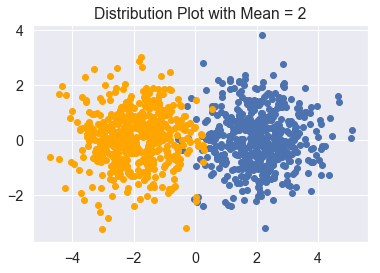

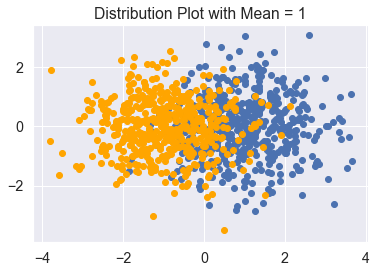

In [7]:
def get_multivariate_sample(n, d, mean):
    x_sample = []
    y_sample = []
    means = np.zeros(d)
    means[0] = mean
    for i in range(n):
        y = np.random.binomial(1, .5)
        if (y == 0):
            x = np.random.multivariate_normal(-means, np.identity(d))
        else:
            x = np.random.multivariate_normal(means, np.identity(d))
        x_sample.append(x.tolist())
        y_sample.append(y)
    return x_sample, y_sample

def split_by_class(sample):
    y_one = [pair for pair in sample if pair[1] == 1]
    y_neg_one = [pair for pair in sample if pair[1] == 0]
    return y_one, y_neg_one

X, y = get_multivariate_sample(1000, 2, 2)
sample = list(zip(X, y))
class_one, class_neg_one = split_by_class(sample)
plt.scatter([x[0] for x in list(zip(*class_one))[0]], [x[1] for x in list(zip(*class_one))[0]], c = 'b')
plt.scatter([x[0] for x in list(zip(*class_neg_one))[0]], [x[1] for x in list(zip(*class_neg_one))[0]], c = 'orange')
plt.title("Distribution Plot with Mean = 2")
plt.show()

X, y = get_multivariate_sample(1000, 2, 1)
sample = list(zip(X, y))
class_one, class_neg_one = split_by_class(sample)
plt.scatter([x[0] for x in list(zip(*class_one))[0]], [x[1] for x in list(zip(*class_one))[0]], c = 'b')
plt.scatter([x[0] for x in list(zip(*class_neg_one))[0]], [x[1] for x in list(zip(*class_neg_one))[0]], c = 'orange')
plt.title("Distribution Plot with Mean = 1")
plt.show()


# Increasing n

In [8]:
def get_cond_entropy_vs_n(mean, d):
    cef_all = []
    cart_all = []
    honest_all = []
    sample_sizes = [i*400 for i in range(1, 26)]
    for i in tqdm_notebook(range(20)):
        cef = []
        cart = []
        honest = []
        for elem in tqdm_notebook(sample_sizes):
            X, y = get_multivariate_sample(elem, d, mean)
            cef.append(cef_estimate(np.array(X), y, 300, .32, depth = 30))
            cart.append(CART_estimate(np.array(X), y, 300, .32, depth = 30))
            honest.append(honesty_estimate(np.array(X), y, 300, .32, depth = 30))
        cef_all.append(cef)
        cart_all.append(cart)
        honest_all.append(honest)
    return sample_sizes, cef_all, cart_all, honest_all

sample_sizes, cef, cart, honest = get_cond_entropy_vs_n(1, 40)


In [ ]:
sns.set(font_scale = 3.5)
sns.set_style("ticks")
plt.figure()
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(sample_sizes, np.mean(cef, axis = 0).flatten(), label = "CF", linewidth = 2, color = "#F41711")
plt.plot(sample_sizes, np.mean(cart, axis = 0).flatten(), label = "CART", linewidth = 2, color = "#35978f")
plt.plot(sample_sizes, np.mean(honest, axis = 0).flatten(), label = "Honesty", linewidth = 2, color = "#fdae61")


for i in range(1, len(cef)):
    plt.plot(sample_sizes, cef[i], linewidth = 4, color = "#F41711", alpha = .15)
    
for i in range(1, len(cart)):
    plt.plot(sample_sizes, cart[i], linewidth = 4, color = "#35978f", alpha = .15)

for i in range(1, len(honest)):
    plt.plot(sample_sizes, honest[i], linewidth = 4, color = "#fdae61", alpha = .15)

line_true = plt.axhline(y=.356,linestyle='-', color = "black", label = "Truth")

plt.xlabel("Sample Size")
plt.ylabel("$\hat H(Y|X)$")
plt.ylim(ymin = 0)
plt.ylim(ymax = .8)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
#plt.legend()
#plt.title("H(Y|X) Estimate vs Sample Size with Mean = 1")
plt.tight_layout()
plt.savefig("alg_comparison_final_noerror_20_40d.pdf")
plt.show()

# Increasing effect size

In [ ]:
from tqdm import tqdm_notebook
def get_cond_entropy_vs_mean(n):
    cef_all = []
    cart_all = []
    honest_all = []
    means = [i*.2 for i in range(1, 26)]
    for i in tqdm_notebook(range(1)):
        cef = []
        cart = []
        honest = []
        for elem in tqdm_notebook(means):
            X, y = get_multivariate_sample(n, 40, elem)
            cef.append(cef_estimate(np.array(X), y, 300, .32, depth = 30))
            cart.append(CART_estimate(np.array(X), y, 300, .32, depth = 30))
            honest.append(honesty_estimate(np.array(X), y, 300, .32, depth = 30))
        return means, cef, cart, honest
        cef_all.append(cef)
        cart_all.append(cart)
        honest_all.append(honest)
    return means, cef_all, cart_all, honest_all

means, cef, cart, honest = get_cond_entropy_vs_mean(10000)


In [ ]:
sns.set(font_scale = 3.5)
sns.set_style("ticks")
plt.figure()
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['figure.figsize'] = [15, 10]

line_cf, = plt.plot(means, cef, label = "CF", linewidth = 4, color = "#F41711")

line_cart, = plt.plot(means, cart, label = 'CART', linewidth = 4, color = "#35978f")

line_honest, = plt.plot(means, honest, label = "Honesty", linewidth = 4, color = "#fdae61")

line_true, = plt.plot(means, truth_conv_0, label = "Truth", linewidth = 4, color = 'black')

plt.ylim(ymin = -.05)
plt.ylim(ymax = .8)
#plt.legend(handles=[line_cf, line_cart, line_honest, line_true])
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
plt.xlabel("Effect Size " + u'(\u03bc)')
plt.ylabel("$\hat H(Y|X)$")
plt.tight_layout()
plt.savefig("alg_comp_40d_n10000_conv0_final_noerror.pdf")
plt.show()